### EDA and Preprocessing to fit into VADER Pretrained Model

In [58]:
# Importing the necessary packages. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import spacy

ImportError: cannot import name 'deprecated' from 'typing_extensions' (/Users/tessanderson/anaconda3/lib/python3.10/site-packages/typing_extensions.py)

In [16]:
# Loading the dataset for preprocessing.
sentiment_data = pd.read_csv('twitter_sentiment_data.csv')
sentiment_data.head(3)

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256


In [17]:
sentiment_data.info()
# Dataset has no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [18]:
# The dataset uses the labels -1: Anti, 0: Neutral, 1: Pro, and 2: News.
# We need to remove any entries under the label 2 as factual news does not fit with VADER pretrained model. 
def change_labels(data):
    
    labels = {-1: 'negative', 0: 'neutral', 1: 'positive'}
    data['sentiment'] = data['sentiment'].map(labels)

    return data[['sentiment', 'message', 'tweetid']]

change_labels(sentiment_data)

,sentiment,message,tweetid
0,negative,@tiniebeany climate change is an interesting h...,792927353886371840
1,positive,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,positive,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,positive,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,NaN,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,positive,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,positive,What will your respective parties do to preven...,791316857403936768
43940,NaN,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,neutral,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


In [20]:
# We succesfully renamed and removed News from the sentiment column, but we need to drop the entries that go with News since we only removed the sentiment values, not the tweets.
sentiment_data.info()
# We do this using dropna()
sentiment_data.dropna(subset=['sentiment'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  34667 non-null  object
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [47]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34667 entries, 0 to 43942
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sentiment         34667 non-null  object
 1   message           34667 non-null  object
 2   tweetid           34667 non-null  int64 
 3   vader_prediction  34667 non-null  object
 4   cleaned           34667 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [46]:
# We will also convert message column to string for easier processing.
sentiment_data['message']=sentiment_data['message'].astype(str)

In [34]:
# To begin processing the messages for EDA, first we will print some messages to understand what adjustments need to be done to format, etc. 
for index, text in enumerate(sentiment_data['message'][0:5]):
    print('Tweet %d:\n'%(index+1),text)

Tweet 1:
 @tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
Tweet 2:
 RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦
Tweet 3:
 Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube
Tweet 4:
 RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im
Tweet 5:
 Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X


In [39]:
# First, we will expand contractions for better analysis using a dictionary of English Contractions from analyticsvidhya.com.
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
sentiment_data['message']=sentiment_data['message'].apply(lambda x:expand_contractions(x))


In [40]:
# Next, we will lowercase all the messages. 
sentiment_data['cleaned']=sentiment_data['message'].apply(lambda x: x.lower())

In [41]:
# Next, we will remove digits and words containing digits.
sentiment_data['cleaned'] = sentiment_data['cleaned'].apply(lambda x: re.sub('\w*\d\w*','',x))

In [50]:
# Finally, we will remove punctuations in the messages. 
sentiment_data['cleaned'] = sentiment_data['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [51]:
# Removing extra spaces
sentiment_data['cleaned']=sentiment_data['cleaned'].apply(lambda x: re.sub(' +', ' ',x))

In [52]:
# Now we can check how our text looks after cleaning.
for index, text in enumerate(sentiment_data['cleaned'][0:5]):
    print("Tweet %d:\n"%(index+1),text)

Tweet 1:
 tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for yes while the suv boom
Tweet 2:
 rt natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change httpstco httã¢â‚¬â¦
Tweet 3:
 fabulous leonardo dicaprio is film on climate change is brilliant do watch httpstco via youtube
Tweet 4:
 rt mickfanning just watched this amazing documentary by leonardodicaprio on climate change we all think thisã¢â‚¬â¦ httpstco
Tweet 5:
 unamshow awache kujinga na iko global warming httpstco


In [56]:
# Using SpaCy for removal of stopwords and lemmatization
import spacy
# loading model
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])

ImportError: cannot import name 'deprecated' from 'typing_extensions' (/Users/tessanderson/anaconda3/lib/python3.10/site-packages/typing_extensions.py)

### Preparing for VADER

In [23]:
# Install and import nltk
import nltk

# Download the lexicon
nltk.download("vader_lexicon")

# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tessanderson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
def format_output(output_dict):
    sentiment = 'neutral'
    if(output_dict['compound']>=0.05):
        sentiment='positive'
    elif(output_dict['compound']<=-0.05):
        sentiment='negative'
    return sentiment
def predict_sentiment(text):
    output_dict = sent_analyzer.polarity_scores(text)
    return format_output(output_dict)

# running the predictions
sentiment_data['vader_prediction']=sentiment_data['message'].apply(predict_sentiment)
sentiment_data.sample(5)

,sentiment,message,tweetid,vader_prediction
40195,neutral,It$q$s so hot in NYC I$q$m schvitzing in my br...,680119968042758145,negative
40368,neutral,https://t.co/cA2LysdLOU Regearing the Global R...,686307413788524544,neutral
28971,positive,A reporter returns to Ohio to discuss the chal...,937197316741779456,positive
39006,positive,"RT @Glen4ONT: #FF Quebec climate champions, Ou...",662756923532574720,positive
6189,positive,since he thinks global warming is a hoax this ...,798969559218814976,positive


In [29]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(sentiment_data['sentiment'],sentiment_data['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(sentiment_data['sentiment'], sentiment_data['vader_prediction']))

Accuracy: 0.34969856059076354

              precision    recall  f1-score   support

    negative       0.14      0.47      0.22      3990
     neutral       0.25      0.26      0.26      7715
    positive       0.62      0.36      0.45     22962

    accuracy                           0.35     34667
   macro avg       0.34      0.36      0.31     34667
weighted avg       0.48      0.35      0.38     34667



<Axes: >

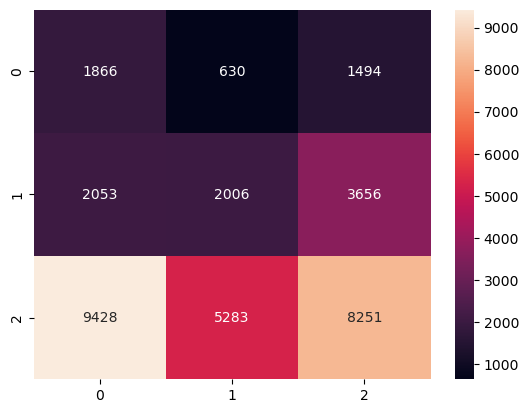

In [72]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(sentiment_data['sentiment'],sentiment_data['vader_prediction'])
sns.heatmap(cf_matrix, annot=True, fmt='g')